In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
train_dir = "/Users/dim__gag/Desktop/stanford-cars-dataset/data/car_data/car_data/train"
valid_dir = "/Users/dim__gag/Desktop/stanford-cars-dataset/data/car_data/car_data/test"

image_size = 224
batch_size = 32
num_workers = 4

In [3]:
# Show images from train directory
train_images = os.listdir(train_dir)
print("Number of images in train directory: ", len(train_images))
print("Sample images from train directory: ", train_images[:5])



Number of images in train directory:  197
Sample images from train directory:  ['Dodge Dakota Crew Cab 2010', 'GMC Canyon Extended Cab 2012', 'Hyundai Santa Fe SUV 2012', 'Dodge Durango SUV 2012', 'Chevrolet Silverado 1500 Extended Cab 2012']


In [4]:
# Show images from valid directory
valid_images = os.listdir(valid_dir)
print("Number of images in valid directory: ", len(valid_images))
print("Sample images from valid directory: ", valid_images[:5])


Number of images in valid directory:  197
Sample images from valid directory:  ['Dodge Dakota Crew Cab 2010', 'GMC Canyon Extended Cab 2012', 'Hyundai Santa Fe SUV 2012', 'Dodge Durango SUV 2012', 'Chevrolet Silverado 1500 Extended Cab 2012']


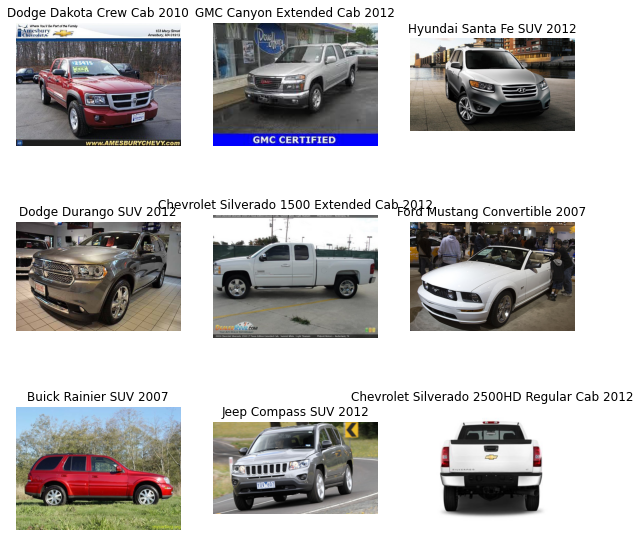

In [5]:
# Plot training images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(train_dir + "/" + train_images[i] + "/" + os.listdir(train_dir + "/" + train_images[i])[0])
    plt.imshow(img)
    plt.title(train_images[i])
    plt.axis("off")

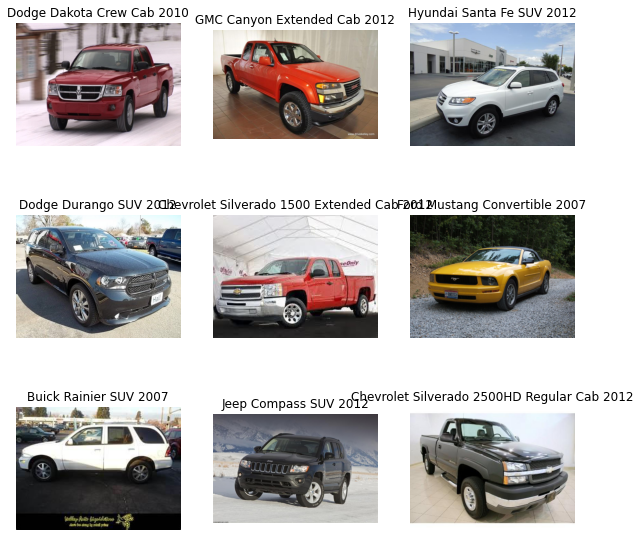

In [6]:
# Plot training images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(valid_dir + "/" + valid_images[i] + "/" + os.listdir(valid_dir + "/" + valid_images[i])[0])
    plt.imshow(img)
    plt.title(valid_images[i])
    plt.axis("off")

In [8]:
# if contains tesla in the name
for i in range(len(train_images)):
    if "tesla" in train_images[i].lower():
        print(train_images[i])
        tesla = train_images[i]



Tesla Model S Sedan 2012


In [9]:
tesla

'Tesla Model S Sedan 2012'

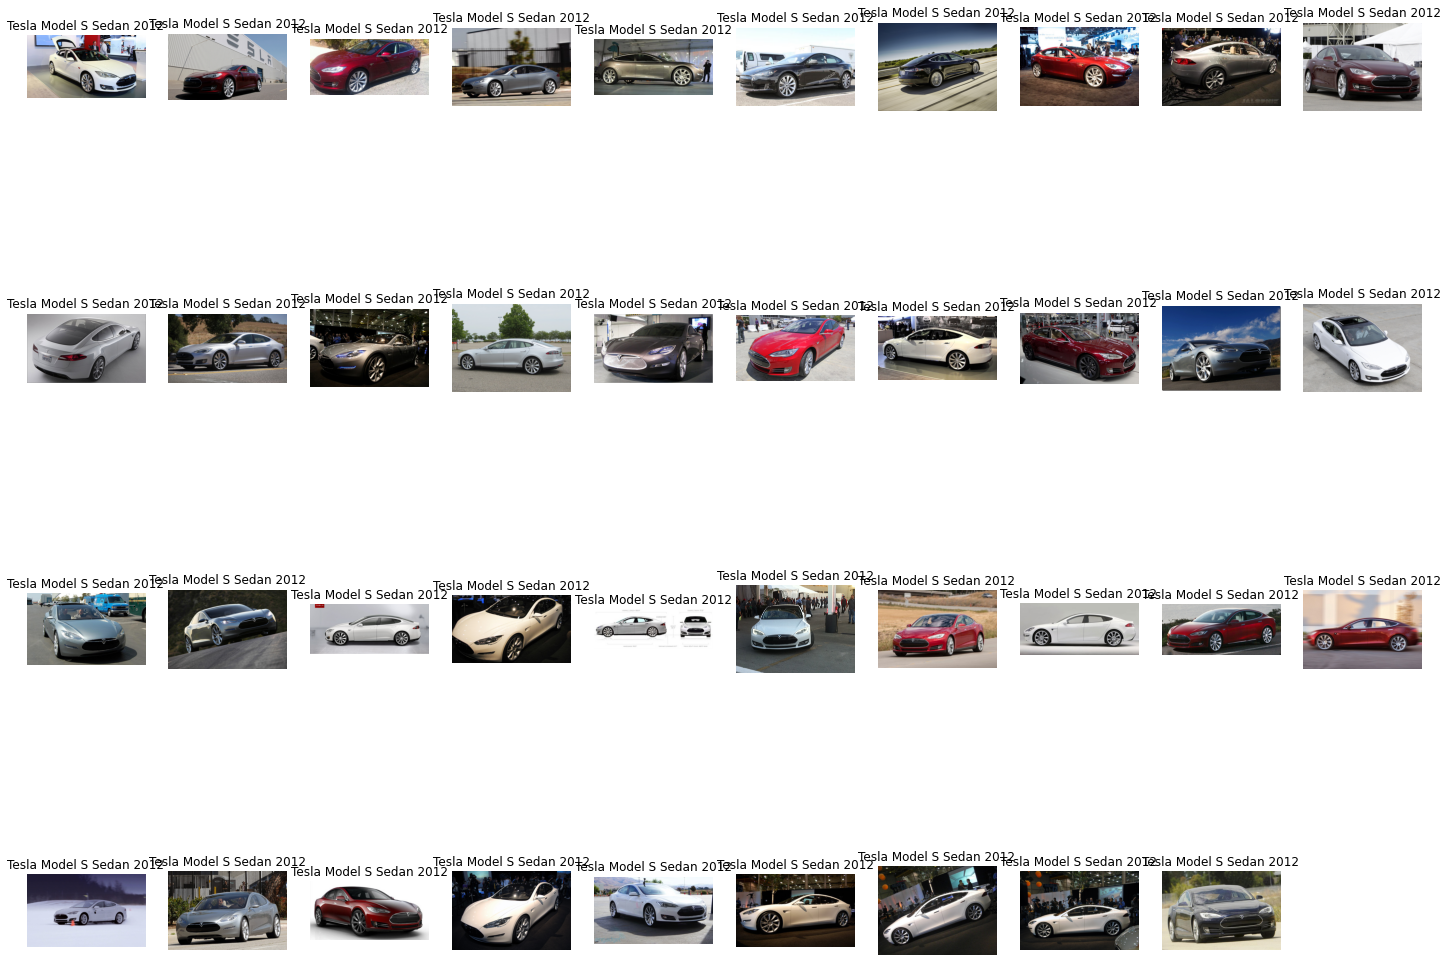

In [21]:
# Plot all tesla images
plt.figure(figsize=(25, 25))
for i in range(len(os.listdir(train_dir + "/" + tesla))):
    plt.subplot(5, 10, i+1)
    img = plt.imread(train_dir + "/" + tesla + "/" + os.listdir(train_dir + "/" + tesla)[i])
    plt.imshow(img)
    plt.title(tesla)
    plt.axis("off")

In [ ]:
# To be continued...
# https://debuggercafe.com/stanford-cars-classification-using-efficientnet-pytorch/